# Такси в аэропорт

## Описание проекта

Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

_______________________________________
##### [1. Подготовка данных](#Part_1)

##### [2. Анализ данных](#Part_2)

##### [3. Обучение моделей](#Part_3)
* [3.1 Линейная регрессия](#Part_3.1)
* [3.2 Дерево регрессии](#Part_3.2)
* [3.3 Случайный лес регрессии](#Part_3.3)
* [3.4 Градиентый бустинг](#Part_3.4)

##### [4. Тестирование моделей](#Part_4)
_________________________________________

<a id='Part_1'></a>
# 1. Подготовка данных
Считаем данные с учетом индексации по дате, отсортируем по возрастанию и проверим на монотонность. Проведем ресемплирование с шагом в 1 час с суммированием данных.

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

In [6]:
data = data.resample('1H').sum()

<a id='Part_2'></a>
# 2. Анализ данных
Изучим данные. Посмотрим на распределения за весь промежуток времени, за полмесяца и за один день.

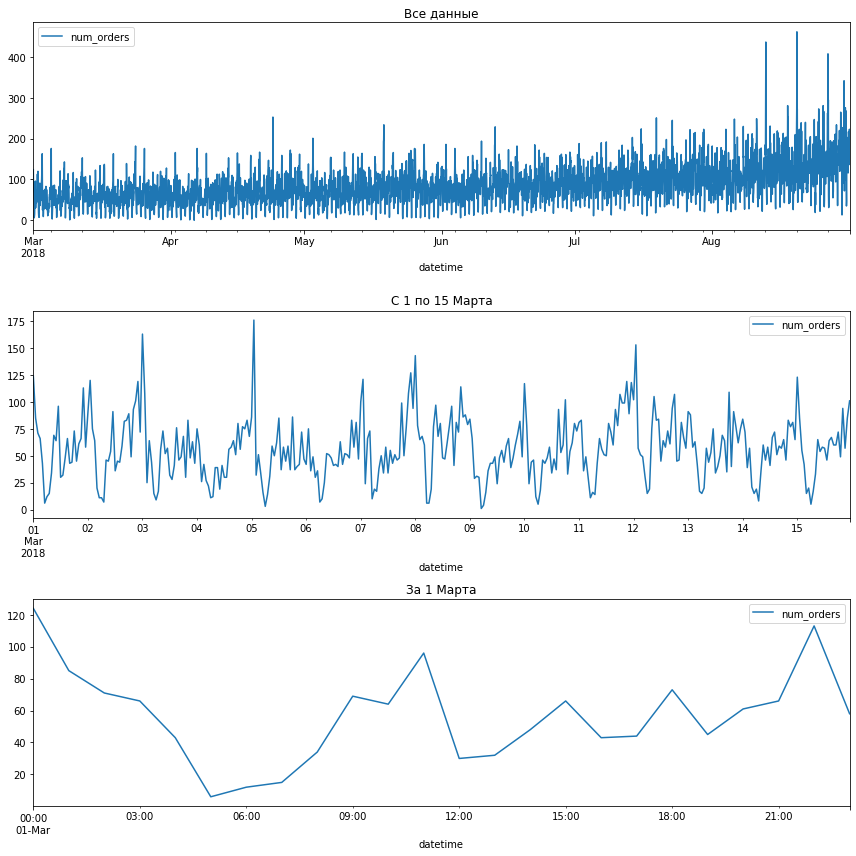

In [7]:
plt.figure(figsize=(12, 12))

plt.subplot(311)
data.plot(ax=plt.gca())
plt.title('Все данные')
plt.subplot(312)
data['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('С 1 по 15 Марта')
plt.subplot(313)
data['2018-03-01'].plot(ax=plt.gca())
plt.title('За 1 Марта')

plt.tight_layout()

### Промежуточный вывод
Предварительно можно сказать, что определенно виден некий тренд и видна цикличность распределения заказа такси по времени. В ночные часы вызовов больше.
___________________________________

Теперь изучим наши данные на сезонность и тренд, для этого проведем семплирование с шагом в 1 день и разложим полученные данные на составляющие.

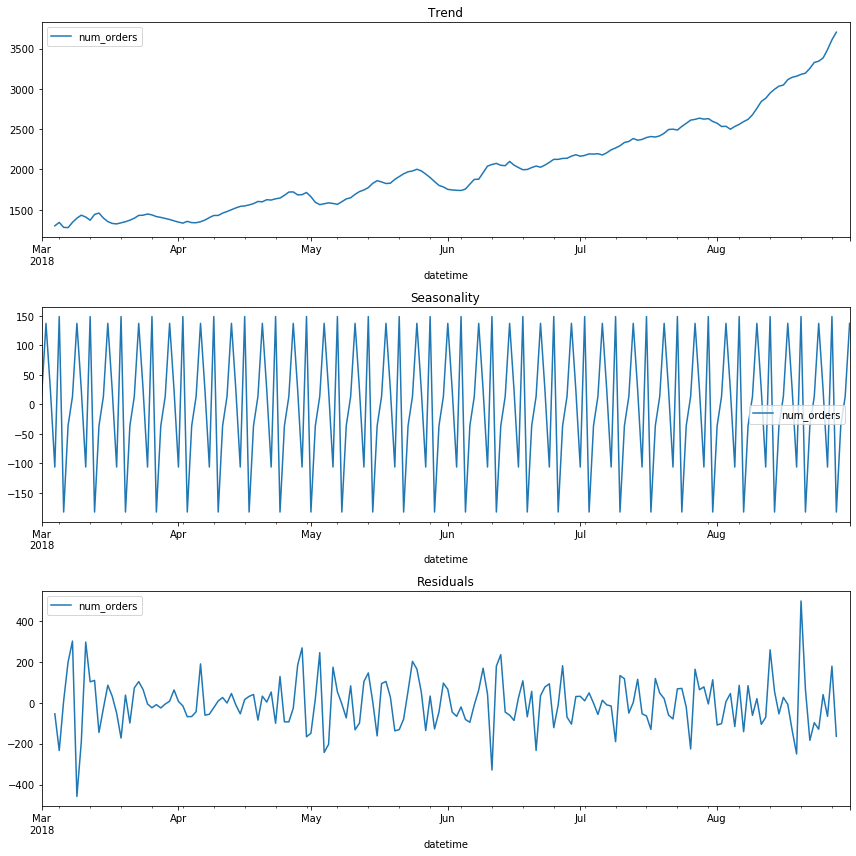

In [8]:
decomposed = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Промежуточный вывод
Мы видим, что в данных есть четко выраженный тренд и сезонность, причем остаток декомпозиции больше похож на шум.

<a id='Part_3'></a>
# 3. Обучение моделей

* Напишем функцию добавления фич в датасет
* Напишем функцию деления датасета на обучающую и тестовую выборку с выделением признаков
* Проведем поиск параметров добавляемых фич с помощью линейной регрессии для минимизации RMSE
* Найдем гиперпараметры для основных моделей и для градиентного бустинга
* На основе подобранных гиперпараметров обучим модели

In [9]:
def make_features(data, max_lag, rolling_mean_size):
    if data.shape[1] > 1:
        data.drop(data.columns[list(data.columns).index('dayofweek')+1:],inplace=True, axis=1)
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [10]:
def feature_target(data):
    train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state=42)
    train = train.dropna()
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']
    return features_train, target_train, features_test, target_test

<a id='Part_3.1'></a>
## 3.1 Линейная регрессия

In [11]:
df2 = pd.DataFrame(columns=['max_lag', 'rolling_mean_size', 'RMSE'])
for i in range(1,100,9):
    for j in range(1,100,12):
        make_features(data, i, j)
        features_train, target_train, features_test, target_test = feature_target(data)

        model = LinearRegression().fit(features_train, target_train)
        LinearRegression_predict = model.predict(features_test)
        rmse = mean_squared_error(target_test, LinearRegression_predict) ** 0.5
        
        df2 = df2.append(pd.DataFrame([[i, j, rmse]], columns = df2.columns))
    if i % 9 == 0:
        print('Iteration №:',i)
        
df2.loc[df2['RMSE'] == df2['RMSE'].min()]

,max_lag,rolling_mean_size,RMSE
0,91,97,40.659067


In [12]:
make_features(data, 91, 97)

In [13]:
features_train, target_train, features_test, target_test = feature_target(data)

In [14]:
features_train.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 01:00:00,0,1,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,55.536082
2018-03-05 02:00:00,0,2,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,56.072165
2018-03-05 03:00:00,0,3,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,55.525773
2018-03-05 04:00:00,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,77.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,55.319588
2018-03-05 05:00:00,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,73.0,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,54.989691


In [15]:
 features_test.head()

,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,0,14,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,...,80.0,201.0,105.0,212.0,127.0,98.0,144.0,80.0,88.0,120.329897
2018-08-13 15:00:00,0,15,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,...,122.0,80.0,201.0,105.0,212.0,127.0,98.0,144.0,80.0,120.567010
2018-08-13 16:00:00,0,16,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,...,47.0,122.0,80.0,201.0,105.0,212.0,127.0,98.0,144.0,121.701031
2018-08-13 17:00:00,0,17,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,...,44.0,47.0,122.0,80.0,201.0,105.0,212.0,127.0,98.0,122.360825
2018-08-13 18:00:00,0,18,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,...,62.0,44.0,47.0,122.0,80.0,201.0,105.0,212.0,127.0,122.381443


In [16]:
LinearRegression_model = LinearRegression().fit(features_train, target_train)

<a id='Part_3.2'></a>
## 3.2 Дерево регрессии

In [17]:
model = DecisionTreeRegressor(random_state=42)
parametrs = {'max_depth': range(1, 15)}
grid = GridSearchCV(model, parametrs, scoring = 'neg_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_, grid.best_score_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


({'max_depth': 5}, -769.2988228511518)

In [18]:
DecisionTreeRegressor_model = DecisionTreeRegressor(max_depth=5, random_state=42).fit(features_train, target_train)

<a id='Part_3.3'></a>
## 3.3 Случайный лес регрессии

In [19]:
model = RandomForestRegressor(random_state=42)
parametrs = { 'n_estimators': range(50, 70, 10),'max_depth': range(11, 15)}
grid = GridSearchCV(model, parametrs, scoring = 'neg_mean_squared_error')
grid.fit(features_train, target_train)
grid.best_params_, grid.best_score_

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


({'max_depth': 14, 'n_estimators': 50}, -580.2839497619411)

In [20]:
RandomForestRegressor_model = RandomForestRegressor(n_estimators=50, max_depth=14, random_state=42).fit(features_train, target_train)

<a id='Part_3.4'></a>
## 3.4 Градиентый бустинг

In [22]:
gbm = lgb.LGBMRegressor(n_estimators=200, random_state=42)
param_set = {'num_leaves':range(40, 90, 10),
             'max_depth':range(5,7,1),
             'learning_rate':np.arange(0.03, 0.07, 0.02)
             }

tscv = TimeSeriesSplit(n_splits=2)
gsearch = GridSearchCV(gbm, param_grid=param_set, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=1)

lgb_model2 = gsearch.fit(features_train, target_train)
lgb_model2.best_params_, lgb_model2.best_score_

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.8min finished


({'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 40}, -646.06504823496)

In [23]:
# model
gbm = lgb.LGBMRegressor(learning_rate=0.05,
                        max_depth = 6,
                        n_estimators=200,
                        num_leaves=40,
                        random_state=42
                       )
# fit
gbm.fit(features_train, target_train,
        eval_set=[(features_train, target_train),(features_test,target_test)],
        eval_metric='rmse',
        early_stopping_rounds=5,
        verbose = 20)

Training until validation scores don't improve for 5 rounds
[20]	training's rmse: 23.7274	training's l2: 562.987	valid_1's rmse: 53.9201	valid_1's l2: 2907.37
[40]	training's rmse: 18.824	training's l2: 354.341	valid_1's rmse: 43.8667	valid_1's l2: 1924.29
[60]	training's rmse: 16.7527	training's l2: 280.653	valid_1's rmse: 40.3374	valid_1's l2: 1627.1
[80]	training's rmse: 15.7119	training's l2: 246.864	valid_1's rmse: 39.144	valid_1's l2: 1532.25
[100]	training's rmse: 14.9561	training's l2: 223.686	valid_1's rmse: 38.6459	valid_1's l2: 1493.51
[120]	training's rmse: 14.3136	training's l2: 204.88	valid_1's rmse: 38.4699	valid_1's l2: 1479.94
[140]	training's rmse: 13.6756	training's l2: 187.023	valid_1's rmse: 38.1196	valid_1's l2: 1453.1
Early stopping, best iteration is:
[139]	training's rmse: 13.6852	training's l2: 187.285	valid_1's rmse: 38.1084	valid_1's l2: 1452.25


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=40, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

<a id='Part_4'></a>
# 4. Тестирование моделей
Сделаем предсказания тестовой выборки подготовленными моделями и рассчитаем метрику RMSE.

In [24]:
# LinearRegression_rmse
LinearRegression_predict_test = LinearRegression_model.predict(features_test)
LinearRegression_rmse = round(mean_squared_error(target_test, LinearRegression_predict_test) ** 0.5, 2)

# DecisionTreeRegressor_rmse
DecisionTreeRegressor_predict_test = DecisionTreeRegressor_model.predict(features_test)
DecisionTreeRegressor_rmse = round(mean_squared_error(target_test, DecisionTreeRegressor_predict_test) ** 0.5, 2)

# RandomForestRegressor_rmse
RandomForestRegressor_predict_test = RandomForestRegressor_model.predict(features_test)
RandomForestRegressor_rmse = round(mean_squared_error(target_test, RandomForestRegressor_predict_test) ** 0.5, 2)

# LGBMRegressor_rmse
LGBMRegressor_predict_test = gbm.predict(features_test, num_iteration=gbm.best_iteration_)
LGBMRegressor_rmse = round(mean_squared_error(target_test, LGBMRegressor_predict_test) ** 0.5, 2)

In [25]:
summary = pd.DataFrame(np.array([['LinearRegression', LinearRegression_rmse],
                             ['DecisionTreeRegressor', DecisionTreeRegressor_rmse], 
                             ['RandomForestRegressor', RandomForestRegressor_rmse],
                             ['LGBMRegressor', LGBMRegressor_rmse]]),
                     columns=['Model', 'RMSE'])
summary

,Model,RMSE
0,LinearRegression,40.66
1,DecisionTreeRegressor,60.16
2,RandomForestRegressor,40.26
3,LGBMRegressor,38.11


Сравним наши предсказания с действительностью.

In [26]:
target_test.index.min(),target_test.index.max()

(Timestamp('2018-08-13 14:00:00'), Timestamp('2018-08-31 23:00:00'))

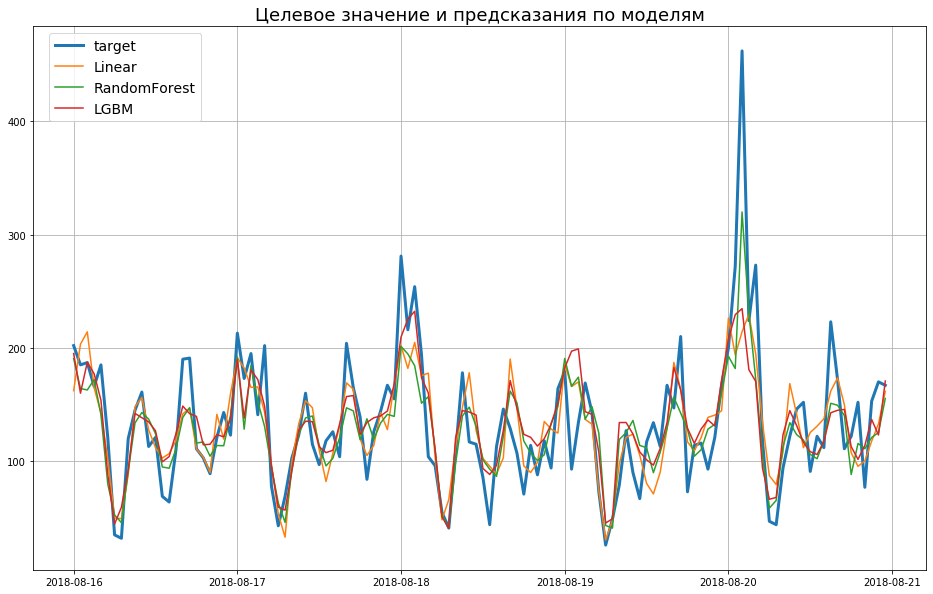

In [27]:
plt.figure(figsize=(16,10))
plt.grid()
plt.title('Целевое значение и предсказания по моделям', fontsize=18)
t1 = '2018-08-16'
t2 = '2018-08-20'
x = target_test[t1:t2].index
y = target_test[t1:t2]
y_p_2 = pd.Series(LinearRegression_predict_test, index=target_test.index)[t1:t2]
y_p_3 = pd.Series(RandomForestRegressor_predict_test, index=target_test.index)[t1:t2]
y_p_4 = pd.Series(LGBMRegressor_predict_test, index=target_test.index)[t1:t2]
plt.plot(x, y, label='target', linewidth=3)
plt.plot(x, y_p_2, label='Linear')
plt.plot(x, y_p_3, label='RandomForest')
plt.plot(x, y_p_4, label='LGBM')
plt.legend(bbox_to_anchor=(0.01, 1), loc='upper left', fontsize=14)

Видим что все модели неплохо предсказывают общую тендецию распределения событий. Однако можно заметить, что предсказания могут быть сдвинуты по времени и часто не попадают в максимум или минимум события. При использовании в дальнейшем это надо будет учитывать.

# Вывод
* Данные были ресемплированы с шагом 1 час
* Проведен анализ данных
* В данные добавлены признаки по дате, временному лагу и скользящему среднему 
* С помощью модели линейной регрессии были подобраны оптимальные значения временного лага и размер окна скользящего среднего (91, 97)
* Проиведен подбор гипер-параметров для моделей с помощью GridSearchCV
* Проведено прогнозирование временного ряда 4-мя разными моделями и 3 из них показали значение метрики RMSE меньше 48
* Проведен графический анализ полученных результатов, который показывает пригодность моделей для использования